In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
import torch.nn.init as init
import time

In [2]:
def np_to_torch(arr):
    
    arr = torch.FloatTensor(arr)
    arr = arr.unsqueeze(-1)
    arr = arr.clone().detach().requires_grad_(True)
    
    return arr

def x_train_data(N_x, x_l, x_r, N_bc, s, t_test, del_t):
    
    x_train = np.linspace(x_l,x_r,N_x)   

    for i in range(N_x):
        if x_train[i]>s:
            break

    x_train = np_to_torch(x_train)
    N_xl = torch.sum( torch.where(x_train == x_l,1,0) ).detach().numpy().item()
    
    return x_train, N_xl, i

def initial_temp(N_x, N_bc, T_l, T_r, N_x_test, N_s, N_s_test):
    
    T_prev_1 = np.concatenate((np.linspace(T_l,T_r,N_s), np.ones(N_x - N_s)*T_r),0)
    T_prev = np_to_torch(T_prev_1)
    T_test_prev = np.concatenate((np.linspace(T_l,T_r,N_s_test), np.ones(N_x_test - N_s)*T_r),0)
    T_test_prev = np.reshape(T_test_prev,(N_x_test, 1))
    
    return T_prev, T_test_prev

def initial_interface(N, s):

    s_interface = torch.full((N, 1), s)
    s_interface = s_interface.clone().detach().requires_grad_(True)
    
    return s_interface, s_interface
            
def xavier_init(m):
    if isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)
    
class ANN(nn.Module):
    def __init__(self, layer_size):
        super(ANN, self).__init__()
        
        # Fully conected model
        modules = []
        for i in range(len(layer_size) - 2):
            modules.append(nn.Linear(layer_size[i], layer_size[i+1]))  
            modules.append(nn.Tanh())
        modules.append(nn.Linear(layer_size[-2], layer_size[-1])) 
#         modules.append(nn.ReLU())

        self.fc = nn.Sequential(*modules)
        for layer in self.fc.modules():
            if isinstance(layer, nn.Linear):
                 layer.weight.data.normal_(mean=0, std=0.2)
#         self.fc.apply(xavier_init)
        
    def forward(self, x_train, k2, del_t, s_ini, t_test, dTsds_prev):
        op = self.fc( x_train )
        op_x = torch.autograd.grad(op, x_train, grad_outputs=torch.ones_like(op), create_graph=True)[0]
        op_x2 = torch.autograd.grad(op_x, x_train, grad_outputs=torch.ones_like(op_x), create_graph=True)[0]
        
        op_s = self.fc( s_ini )
        op_s_x = torch.autograd.grad(op_s, s_ini, grad_outputs=torch.ones_like(op_s), create_graph=True)[0]
        
        c_prev = 1
        c_new = 1 - c_prev
            
        s_new = s_ini - del_t*k2*(c_new*op_s_x + c_prev*dTsds_prev)
        op_s_new = self.fc( s_new )
        op_s_new_x = torch.autograd.grad(op_s_new, s_new, grad_outputs=torch.ones_like(op_s_new), create_graph=True)[0]
        op_s_new_x2 = torch.autograd.grad(op_s_new_x, s_new, grad_outputs=torch.ones_like(op_s_new), create_graph=True)[0]

        return op, op_x2, op_s_new, s_new, op_s_x, op_s_new_x2
    
def get_loss(x_train, k1, k2, N_tot, T_l, T_r, N_xl, x_l, x_r, T_prev, del_t, t_test, s_ini, dTsds_prev):
    
    mse = nn.MSELoss(reduction='sum')
    w1 = 1
    w2 = 1
    w3 = 1
        
    T, d2Tdx2, Ts, s_new, _, d2Tdx2_s_new  = model(x_train, k2, del_t, s_ini, t_test, dTsds_prev)
    N1 = torch.sum(torch.where(x_train <= s_new,1,0)).detach().numpy().item()
    eq1 = w1*( torch.sum( torch.square( torch.mul(torch.where(x_train <= s_new,1,0),T - T_prev - del_t*k1*d2Tdx2 ) ) ) )/(N1)
    bc1 = w2*torch.sum( torch.square( torch.mul(torch.where(x_train == x_l,1,0),(T - T_l)) ) )/(N_xl)
    bc2 = w3*torch.sum( torch.square( T_r - Ts ) )

    loss = eq1 + bc1 + bc2   
    
    return loss, eq1, bc1, bc2

def print_loss(epoch, loss, eq1, bc1, bc2):
    print('epoch = ',epoch)
    print('loss = ',loss.detach().numpy())
    print('eq1_loss = ',eq1.detach().numpy())
    print('bc1_loss = ',bc1.detach().numpy())
    print('bc2_loss = ',bc2.detach().numpy())

def interface_identifier(y_pred, T_r, N, x_test, s):
    
    for i in range(N):
        if x_test[i]>s:
            break
            
    for j in range(i,N):
        y_pred[j] = T_r

    return y_pred, s

def lamb_analytical(k1, k2):
    x = []
    er = []
    cnt = 0
    for i in np.arange(0.1, 5, 0.001):
        x.append(i)
        er.append(math.erf(x[-1]))
        cnt = cnt+1

    x = np.array(x)
    er = np.array(er)
    y =[]
    y = np.exp(-x*x)/(er*math.sqrt(math.pi))-x*k1/k2

    for i in range(1,cnt):
        if(y[i]*y[i-1]<0):
            lam = x[i]
            break
    
    return lam

def analytical(N_x_test, x_test, t_test, T_r, k1, k2, T_l):

    x_test = x_test.detach().numpy()
    y_an = np.zeros((N_x_test, 1))
    lam = lamb_analytical(k1, k2)
    s = np.sqrt(k1*t_test)*2*lam
    
    for j in range(N_x_test):
        if(x_test[j]<s):
            y_an[j] = T_l - T_l*math.erf( x_test[j]/( 2*np.sqrt(k1*t_test) ) )/ math.erf(lam) 
        else:
            y_an[j] = T_r
            
    y_an = np.reshape(y_an, (N_x_test, 1))
    
    return y_an, s
    
def train_model(model, optimiser1, epochs, T_r, T_l, k1, k2, N_x, x_l, x_r, N_t, N_bc, accuracy_cap, N_x_test, del_t, s_initial):
    
    loss_store = []
    T_store_pred = []
    s_store_pred = []
    T_store_an = []
    s_store_an = []
    t_store = []
    mse = nn.MSELoss(reduction='sum')
    model.train()  
    
#     N_tot = N_x + N_bc
    N_tot = N_x
    print("N_tot = ", N_tot)
    
    t_test = 0
    
    t_store.append(0)
    s_store_an.append(0)
    for i in range(N_t):
        
        t_test = t_test + del_t
        t_store.append(t_test)
        print("t = ", t_test)
        print(" ")
        
        if(i==0):
            x_train, N_xl, N_s = x_train_data(N_x, x_l, x_r, N_bc, s_initial, t_test, del_t)
            print("Ns = ", N_s)
            T_prev, _ = initial_temp(N_x, N_bc, T_l, T_r, N_x_test, N_s, N_s)
            s_prev, _ = initial_interface(1, s_initial)
            T_store_pred.append(T_prev.detach().numpy())
            s_store_pred.append(s_prev.detach().numpy())
            slope = (T_r - T_l)/s_initial
            print("slope = ", slope)
            dTsds_prev =torch.FloatTensor( np.ones((1, 1))*slope )
        print("slope at interface = ", dTsds_prev)
#         print(T_prev)
    
        if i>2:
                epochs = 2001
    
        for epoch in range(epochs):
            
            #Backpropogation and optimisation
            loss, eq1, bc1, bc2 = get_loss(x_train, k1, k2, N_tot, T_l, T_r, N_xl, x_l, x_r, T_prev, del_t, t_test, s_prev, dTsds_prev)
            optimiser1.zero_grad()
            loss.backward()
            optimiser1.step()  
            loss_store.append(loss.detach().numpy())
            
            if epoch%2000==0:
                print_loss(epoch, loss, eq1, bc1, bc2)
                print("")

#             if loss<0.0004 :
#                 print("loss limit attained, epoch = ", epoch)
#                 print_loss(epoch, loss, eq1, bc1, bc2)
#                 print("")
#                 break
                    
        # Store the results after each time step
        T_prev,_,_,s_prev,dTsds_prev,_ = model(x_train, k2, del_t, s_prev, t_test, dTsds_prev) 
        dTsds_prev = dTsds_prev.clone().detach().requires_grad_(False)
        T_prev = T_prev.detach().numpy()
        T_prev, _ = interface_identifier(T_prev, T_r, N_tot, x_train.detach().numpy(), s_prev[0][0].detach().numpy())
        s_prev = s_prev.detach().numpy()
        print("interface_PINN = ", s_prev[0][0])
        T_an, s_an = analytical(N_x, x_train, t_test, T_r, k1, k2, T_l)
        print("interface_Analytical = ", s_an)
        
        T_store_pred.append(T_prev)
        
        T_store_an.append(T_an)
        s_store_pred.append(s_prev)
        s_store_an.append(s_an)
        
        T_prev = torch.FloatTensor(T_store_pred[-1]).clone().detach().requires_grad_(False)
        s_prev = torch.FloatTensor(s_store_pred[-1]).clone().detach().requires_grad_(True)
        
        print("broke inner loop")
        print("")

    return loss_store, T_store_pred, T_store_an, x_train, s_store_pred, s_store_an, t_store

In [3]:
N_x = 3001
N_bc = 30
N_t = 100
del_t = 0.001
x_l = 0
x_r = 0.28
T_r = 0
T_l = 0.5
t_i = 0
accuracy_cap = 0.00035
N_x_test = 251
s_initial = 0.0015

# Neural network params
layer_size = [1, 3, 3, 3, 1]

# material params
k1 = 0.01
k2 = 0.005

# Training data and initial data
model = ANN(layer_size)
print(model)
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters in the model:", total_trainable_params)

# # Setup Loss function and Optimiser
lr = 1e-4
epochs = 50001
optimiser1 = torch.optim.Adam(model.parameters(), lr=lr)

# Training model
start = time.time()
loss_store, T_store_pred, T_store_an, x_test_np, s_pred, s_an, t = train_model(model, optimiser1, epochs, T_r, T_l, k1, k2, N_x, x_l, x_r, N_t, N_bc, accuracy_cap, N_x_test, del_t, s_initial)
end = time.time()
time_elapsed = end - start
print("time elapsed = ", time_elapsed)

ANN(
  (fc): Sequential(
    (0): Linear(in_features=1, out_features=3, bias=True)
    (1): Tanh()
    (2): Linear(in_features=3, out_features=3, bias=True)
    (3): Tanh()
    (4): Linear(in_features=3, out_features=3, bias=True)
    (5): Tanh()
    (6): Linear(in_features=3, out_features=1, bias=True)
  )
)
Total trainable parameters in the model: 34
N_tot =  3001
t =  0.001
 
Ns =  17
slope =  -333.3333333333333
slope at interface =  tensor([[-333.3333]])
epoch =  0
loss =  0.3584315
eq1_loss =  0.056948382
bc1_loss =  0.2992662
bc2_loss =  0.0022169133

epoch =  2000
loss =  0.16273375
eq1_loss =  0.034219723
bc1_loss =  0.08528278
bc2_loss =  0.043231253

epoch =  4000
loss =  0.1627082
eq1_loss =  0.03428219
bc1_loss =  0.085038565
bc2_loss =  0.043387443

epoch =  6000
loss =  0.16267836
eq1_loss =  0.034278706
bc1_loss =  0.08502117
bc2_loss =  0.043378484

epoch =  8000
loss =  0.16261129
eq1_loss =  0.034269255
bc1_loss =  0.0849877
bc2_loss =  0.04335433

epoch =  10000
loss

epoch =  30000
loss =  7.005036e-05
eq1_loss =  7.000122e-05
bc1_loss =  1.6498891e-08
bc2_loss =  3.2638642e-08

epoch =  32000
loss =  6.994762e-05
eq1_loss =  6.989904e-05
bc1_loss =  1.6346124e-08
bc2_loss =  3.223073e-08

epoch =  34000
loss =  6.984613e-05
eq1_loss =  6.97979e-05
bc1_loss =  1.559295e-08
bc2_loss =  3.2638642e-08

epoch =  36000
loss =  6.9745e-05
eq1_loss =  6.9696944e-05
bc1_loss =  1.4026714e-08
bc2_loss =  3.4031533e-08

epoch =  38000
loss =  6.965448e-05
eq1_loss =  6.959786e-05
bc1_loss =  4.673982e-09
bc2_loss =  5.1951247e-08

epoch =  40000
loss =  6.954474e-05
eq1_loss =  6.94986e-05
bc1_loss =  1.7320417e-08
bc2_loss =  2.881643e-08

epoch =  42000
loss =  6.9445094e-05
eq1_loss =  6.939901e-05
bc1_loss =  1.5061662e-08
bc2_loss =  3.1022385e-08

epoch =  44000
loss =  6.934596e-05
eq1_loss =  6.930087e-05
bc1_loss =  1.7273383e-08
bc2_loss =  2.7813499e-08

epoch =  46000
loss =  6.924774e-05
eq1_loss =  6.9203015e-05
bc1_loss =  1.6452987e-08
bc2_lo

epoch =  2000
loss =  7.809044e-06
eq1_loss =  7.5564176e-06
bc1_loss =  1.2849524e-07
bc2_loss =  1.2413153e-07

interface_PINN =  0.0105581805
interface_Analytical =  0.013794129185997947
broke inner loop

t =  0.023000000000000013
 
slope at interface =  tensor([[-44.2374]])
epoch =  0
loss =  0.00013886212
eq1_loss =  3.6478796e-05
bc1_loss =  1.2862347e-07
bc2_loss =  0.0001022547

epoch =  2000
loss =  7.1310587e-06
eq1_loss =  6.8860536e-06
bc1_loss =  1.2116743e-07
bc2_loss =  1.2383771e-07

interface_PINN =  0.010779368
interface_Analytical =  0.014104148325935897
broke inner loop

t =  0.024000000000000014
 
slope at interface =  tensor([[-43.3309]])
epoch =  0
loss =  0.00012768638
eq1_loss =  3.3156903e-05
bc1_loss =  1.2120893e-07
bc2_loss =  9.4408264e-05

epoch =  2000
loss =  6.4949268e-06
eq1_loss =  6.262223e-06
bc1_loss =  1.14095e-07
bc2_loss =  1.18608355e-07

interface_PINN =  0.010996022
interface_Analytical =  0.014407498047891605
broke inner loop

t =  0.025000

epoch =  2000
loss =  1.7151904e-06
eq1_loss =  1.6393045e-06
bc1_loss =  3.6584712e-08
bc2_loss =  3.93011e-08

interface_PINN =  0.014663082
interface_Analytical =  0.01950784457596484
broke inner loop

t =  0.04500000000000003
 
slope at interface =  tensor([[-31.8544]])
epoch =  0
loss =  3.674898e-05
eq1_loss =  9.0053545e-06
bc1_loss =  3.6607517e-08
bc2_loss =  2.770702e-05

epoch =  2000
loss =  1.6191634e-06
eq1_loss =  1.5426128e-06
bc1_loss =  3.540865e-08
bc2_loss =  4.1141877e-08

interface_PINN =  0.014822354
interface_Analytical =  0.019728279195104698
broke inner loop

t =  0.046000000000000034
 
slope at interface =  tensor([[-31.5120]])
epoch =  0
loss =  3.5344234e-05
eq1_loss =  8.680986e-06
bc1_loss =  3.5453528e-08
bc2_loss =  2.6627793e-05

epoch =  2000
loss =  1.5365166e-06
eq1_loss =  1.4646625e-06
bc1_loss =  3.3702463e-08
bc2_loss =  3.815163e-08

interface_PINN =  0.014979914
interface_Analytical =  0.019946277848260332
broke inner loop

t =  0.047000000000

epoch =  2000
loss =  6.7446433e-07
eq1_loss =  6.4035953e-07
bc1_loss =  1.6103176e-08
bc2_loss =  1.8001604e-08

interface_PINN =  0.017838512
interface_Analytical =  0.023892132596317162
broke inner loop

t =  0.06700000000000005
 
slope at interface =  tensor([[-26.1782]])
epoch =  0
loss =  1.6665224e-05
eq1_loss =  3.9952147e-06
bc1_loss =  1.6300433e-08
bc2_loss =  1.2653709e-05

epoch =  2000
loss =  6.4775026e-07
eq1_loss =  6.1306946e-07
bc1_loss =  1.5952256e-08
bc2_loss =  1.8728542e-08

interface_PINN =  0.017969402
interface_Analytical =  0.024072453136313326
broke inner loop

t =  0.06800000000000005
 
slope at interface =  tensor([[-25.9878]])
epoch =  0
loss =  1.617826e-05
eq1_loss =  3.846508e-06
bc1_loss =  1.5847036e-08
bc2_loss =  1.2315904e-05

epoch =  2000
loss =  6.2250797e-07
eq1_loss =  5.884871e-07
bc1_loss =  1.5503762e-08
bc2_loss =  1.851706e-08

interface_PINN =  0.01809934
interface_Analytical =  0.024251432947353876
broke inner loop

t =  0.0690000000

epoch =  2000
loss =  3.4580103e-07
eq1_loss =  3.2542283e-07
bc1_loss =  9.197553e-09
bc2_loss =  1.118066e-08

interface_PINN =  0.020524887
interface_Analytical =  0.027588258371995893
broke inner loop

t =  0.08900000000000007
 
slope at interface =  tensor([[-22.7486]])
epoch =  0
loss =  9.51041e-06
eq1_loss =  2.262556e-06
bc1_loss =  9.094947e-09
bc2_loss =  7.2387584e-06

epoch =  2000
loss =  3.426489e-07
eq1_loss =  3.2361856e-07
bc1_loss =  8.835347e-09
bc2_loss =  1.0194995e-08

interface_PINN =  0.02063863
interface_Analytical =  0.027744567035727943
broke inner loop

t =  0.09000000000000007
 
slope at interface =  tensor([[-22.6229]])
epoch =  0
loss =  9.265826e-06
eq1_loss =  2.1954943e-06
bc1_loss =  8.801763e-09
bc2_loss =  7.0615297e-06

epoch =  2000
loss =  3.3154072e-07
eq1_loss =  3.126063e-07
bc1_loss =  8.679169e-09
bc2_loss =  1.0255267e-08

interface_PINN =  0.020751745
interface_Analytical =  0.027900000000000025
broke inner loop

t =  0.09100000000000007


# Results Plotter

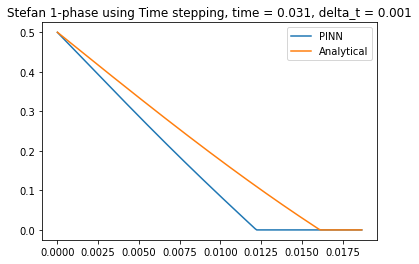

In [4]:
j = 30
i = 0
k = 201

plt.plot(x_test_np[i:k].detach().numpy(), T_store_pred[j][i:k])
plt.plot(x_test_np[i:k].detach().numpy(), T_store_an[j-1][i:k])
Title = "Stefan 1-phase using Time stepping, " + "time = " + str((j+1)*del_t) + ", delta_t = " + str(del_t)
plt.title(Title)
plt.legend(["PINN", "Analytical"])
plt.show()

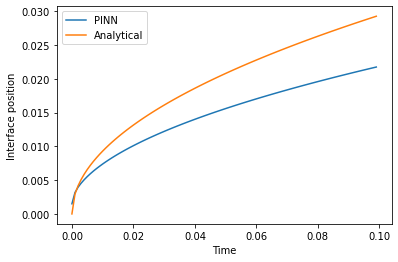

In [5]:
tp = []
for i in range(len(s_pred)):
    tp.append(s_pred[i][0])

i = 0
j = 100
plt.plot(t[i:j], tp[i:j])
plt.plot(t[i:j], s_an[i:j])
plt.legend(["PINN", "Analytical"])
plt.xlabel('Time')
plt.ylabel('Interface position')
plt.show()

In [6]:
s_an

[0,
 0.002940918223956595,
 0.004159086438149612,
 0.005093819784798048,
 0.00588183644791319,
 0.006576093065034897,
 0.0072037490239458,
 0.007780938246766908,
 0.008318172876299225,
 0.008822754671869784,
 0.009300000000000006,
 0.009753922287982417,
 0.010187639569596098,
 0.010603631453421993,
 0.011003908396565296,
 0.011390127303941788,
 0.011763672895826381,
 0.012125716473676938,
 0.012477259314448838,
 0.012819165339443918,
 0.013152186130069797,
 0.01347698037395619,
 0.013794129185997947,
 0.014104148325935897,
 0.014407498047891605,
 0.014704591119782978,
 0.014995799411835315,
 0.015281459354394148,
 0.01556187649353382,
 0.01583732932031157,
 0.016108072510390575,
 0.016374339681342897,
 0.016636345752598453,
 0.01689428897586402,
 0.017148352690564788,
 0.017398706848498847,
 0.017645509343739575,
 0.01788890717735437,
 0.01812903748134469,
 0.01836602842206231,
 0.01860000000000002,
 0.018831064760124448,
 0.019059328424684874,
 0.0192848904585948,
 0.01950784457596484

In [7]:
tp

[array([0.0015], dtype=float32),
 array([0.00316667], dtype=float32),
 array([0.00395654], dtype=float32),
 array([0.00455113], dtype=float32),
 array([0.0050664], dtype=float32),
 array([0.00552857], dtype=float32),
 array([0.00595152], dtype=float32),
 array([0.00634389], dtype=float32),
 array([0.0067117], dtype=float32),
 array([0.00705926], dtype=float32),
 array([0.00738972], dtype=float32),
 array([0.00770549], dtype=float32),
 array([0.00800833], dtype=float32),
 array([0.00829971], dtype=float32),
 array([0.00858088], dtype=float32),
 array([0.00885285], dtype=float32),
 array([0.00911648], dtype=float32),
 array([0.00937252], dtype=float32),
 array([0.00962161], dtype=float32),
 array([0.00986429], dtype=float32),
 array([0.010101], dtype=float32),
 array([0.01033217], dtype=float32),
 array([0.01055818], dtype=float32),
 array([0.01077937], dtype=float32),
 array([0.01099602], dtype=float32),
 array([0.0112084], dtype=float32),
 array([0.01141677], dtype=float32),
 array([0.